### Import the libraries

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

### Define Constants and Inputs

In [7]:
tickers = [
    'SPY',
    'QQQ',
    'TLT',
    'GLD',
    'VNQ',
    'EEM'
]
trading_days = 252       # Approx. trading days in a year
risk_free_rate = 0.0     # Simplified assumption

### Fetch and save price data

In [ ]:
portfolio_data = []
for ticker in tickers:
    data = yf.download(ticker, start='2020-11-01', end='2025-11-01', auto_adjust=True)
    
    # Check for data availability
    if data.empty:
        continue

    # Using Adjusted Close prices
    prices = data["Close"]
    prices.name = ticker  
    portfolio_data.append(prices)

# Combine all assets into a single DataFrame
portfolio_df = pd.concat(portfolio_data, axis = 1)
portfolio_df.reset_index(inplace=True) 

portfolio_df.to_csv("etf_portfolio_prices.csv", index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Load Saved Data

In [9]:
# Load the saved stock info CSV
df = pd.read_csv('etf_portfolio_prices.csv', parse_dates=['Date'], index_col='Date')
df.head()

,SPY,QQQ,TLT,GLD,VNQ,EEM
Date,,,,,,
2020-11-02,307.832550,261.859070,136.335526,177.910004,64.684700,40.449993
2020-11-03,313.267578,266.388672,135.544525,178.919998,65.930237,40.628654
2020-11-04,320.268829,278.279877,138.484833,178.820007,66.045708,41.906120
2020-11-05,326.515076,285.534821,138.725525,182.929993,66.359154,42.620785
2020-11-06,326.440430,285.748230,137.049103,183.190002,65.905495,42.817318


### Calculate Daily Returns

In [10]:
daily_returns = df.pct_change().dropna()
daily_returns.head()

,SPY,QQQ,TLT,GLD,VNQ,EEM
Date,,,,,,
2020-11-03,0.017656,0.017298,-0.005802,0.005677,0.019256,0.004417
2020-11-04,0.022349,0.044639,0.021693,-0.000559,0.001751,0.031442
2020-11-05,0.019503,0.026071,0.001738,0.022984,0.004746,0.017054
2020-11-06,-0.000229,0.000747,-0.012084,0.001421,-0.006836,0.004611
2020-11-09,0.012566,-0.020434,-0.021015,-0.044271,0.035419,0.006885


### Daily Returns & Volatility

In [11]:
mean_returns = daily_returns.mean()
volatility = daily_returns.std()

### Annualize Returns & Volatility

In [12]:
annual_mean_returns = mean_returns * trading_days
annual_volatility = volatility * np.sqrt(trading_days)

### Weighting Strategies

1. Equal Weights (Baseline)

In [13]:
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

2. Volatility-based Weights (less risk = more weight)

In [14]:
# Inverse volatility weights
inv_vol = 1 / volatility
# normalize to sum 1
vol_weights = inv_vol / inv_vol.sum()
vol_weights

SPY    0.174084
QQQ    0.131439
TLT    0.184662
GLD    0.191273
VNQ    0.156308
EEM    0.162235
dtype: float64

3. Sharpe-based Weights (higher Sharpe = more weight)

In [15]:
# Daily Sharpe ratio
sharpe_ratio = mean_returns / volatility
# Sharpe-based weights
sharpe_weights = sharpe_ratio / sharpe_ratio.sum()
sharpe_weights

SPY    0.303654
QQQ    0.265172
TLT   -0.129965
GLD    0.302615
VNQ    0.129269
EEM    0.129254
dtype: float64

Choose which weighting strategy to analyze

In [16]:
weights = sharpe_weights.values      # You may switch between equal_weights, vol_weights, sharpe_weights, or any other based on your prefrences
weights

array([ 0.30365358,  0.26517245, -0.12996458,  0.30261549,  0.12926937,
        0.12925369])

### Portfolio Performance Metrics

Correlation Matrix

In [17]:
cov_matrix = daily_returns.cov()
cov_matrix

,SPY,QQQ,TLT,GLD,VNQ,EEM
SPY,0.000117,0.000146,0.000006,0.000012,0.000090,0.000084
QQQ,0.000146,0.000205,0.000012,0.000016,0.000096,0.000111
TLT,0.000006,0.000012,0.000104,0.000025,0.000030,0.000007
GLD,0.000012,0.000016,0.000025,0.000097,0.000021,0.000033
VNQ,0.000090,0.000096,0.000030,0.000021,0.000145,0.000067
EEM,0.000084,0.000111,0.000007,0.000033,0.000067,0.000134


1. Portfolio expected returns - daily and annual

In [18]:
# Daily portfolio returns
portfolio_returns_daily = np.dot(weights, mean_returns)

# Annualized portfolio returns
portfolio_returns_annual = portfolio_returns_daily * trading_days

2. Portfolio risks - daily and annual

In [19]:
# Daily portfolio volatility
portfolio_vol_daily = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Annualized volatility (optional)
portfolio_vol_annual = portfolio_vol_daily * np.sqrt(trading_days)

3. Sharpe ratio

In [20]:
portfolio_sharpe = (portfolio_returns_annual - risk_free_rate) / portfolio_vol_annual
portfolio_sharpe

np.float64(1.171180512891041)

### Monte Carlo Simulation (Random Portfolios)

In [21]:
num_assets = len(daily_returns.columns)
num_portfolios = 5000

all_returns = []
all_volatility = []

for _ in range(num_portfolios):
    w = np.random.random(num_assets)
    w /= np.sum(w)
    r = np.dot(w, mean_returns) * trading_days
    vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * np.sqrt(trading_days)
    all_returns.append(r)
    all_volatility.append(vol)

all_returns = np.array(all_returns)
all_volatility = np.array(all_volatility)

### Risk-Return Visualization

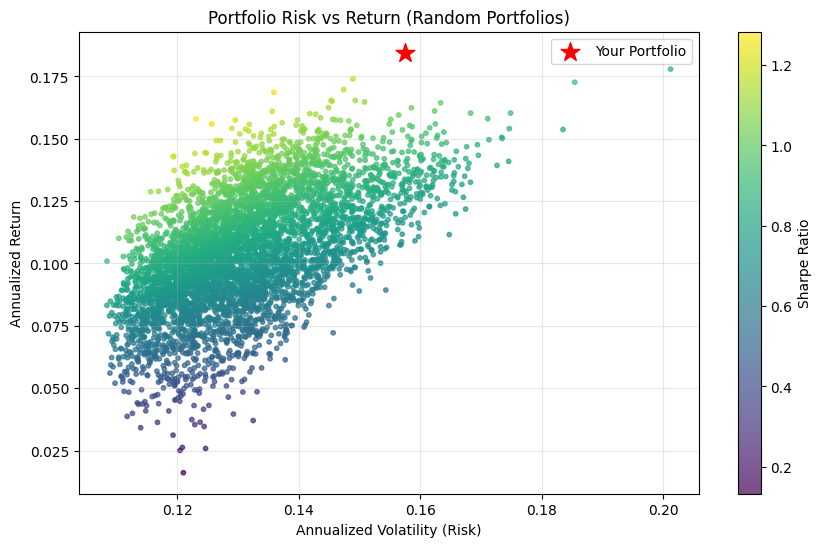

In [22]:
def extract_scalar(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values.flatten()[0]
    elif isinstance(x, (np.ndarray, list)):
        return np.array(x).flatten()[0]
    else:
        return float(x)

ret_value = extract_scalar(portfolio_returns_annual)
vol_value = extract_scalar(portfolio_vol_annual)

plt.figure(figsize=(10,6))
plt.scatter(all_volatility, all_returns, c=all_returns/all_volatility, cmap='viridis', marker='o', s=10, alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_value, ret_value, color='red', marker='*', s=200, label='Your Portfolio')

plt.title('Portfolio Risk vs Return (Random Portfolios)')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')

plt.legend()
plt.grid(alpha=0.3)
plt.show()